#Assignment 1:
    test if the distribution of ages is the same for 
    
    1) male and femal riders
    
    2) day and night riders
    
    use 3 tests: KS, Pearson's, Spearman's

my usual imports and setups

In [1]:
import pylab as pl
import pandas as pd
import numpy as np
%pylab inline

import os

#this makes my plots pretty! but it is totally not mandatory to do it
#import json
#s = json.load( open(os.getenv ('PUI2015')+"/fbb_matplotlibrc.json") )
#pl.rcParams.update(s)


Populating the interactive namespace from numpy and matplotlib


I am reading in data from January 2015. It would be a good idea to use data from warmer months, since there are more riders in the warm weather and the more data the smaller the STATISTICAL NOISE. If you are ambitios you can use data from multiple months, thus addressing systematic errors as well

In [2]:
df = pd.read_csv('july15bikes.csv') #COMMENT THIS OUT BEFORE RUNNING ON YOUR MACHINE
#df = pd.read_csv(os.getenv ('PUI2015')+'/notebooks/data/201507-citibike-tripdata.csv') #UNCOMMENT THIS TO RUN ON YOUR MACHINE

#converting string-formatted datetime to datetime64
df['ts'] = pd.to_datetime(df.starttime, format = '%m/%d/%Y %H:%M:%S')
print df.columns

Index([u'tripduration', u'starttime', u'stoptime', u'start station id', u'start station name', u'start station latitude', u'start station longitude', u'end station id', u'end station name', u'end station latitude', u'end station longitude', u'bikeid', u'usertype', u'birth year', u'gender', u'ts'], dtype='object')


#BY GENDER
splitting data by gender and extracting the age happens in the cell below

In [3]:
#df is the dataframe where the content of the csv file is stored
df['ageM'] = 2015-df['birth year'][(df['usertype'] == 'Subscriber') & (df['gender'] == 1)]
df['ageF'] = 2015-df['birth year'][(df['usertype'] == 'Subscriber') & (df['gender'] == 2)]

lets splot age in 10 year bins. the dataset is very large, so i could be split in smaller bins, but I will chose 10 years in the interest of time. if i was to do this "for real" the bin size choice should be a balance between properly sample the age space, have enough counts in each bin that the statistical noise is not significant (remember that is > sqrt(N)!) and the computational requirement to computatinal facilities ratio. 

the next several steps are needed if you want to code up the KS test from scratch. that is for extra credit, so if you do not want to do it you may not need to plot split the distribution in bins and create the cumulative HOWEVER it is a great idea to do it anyways to explore your data viaually! remember Ascombe's quartet!!

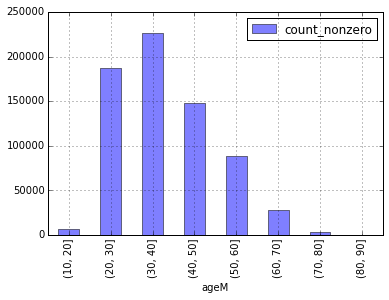

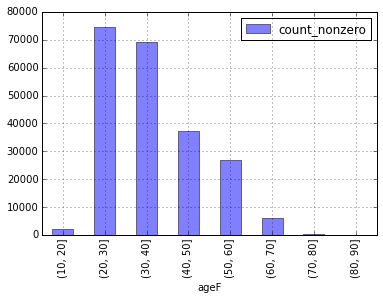

In [8]:
bins = np.arange(10, 99, 10)
df.ageM.groupby(pd.cut(df.ageM, bins)).agg([count_nonzero]).plot(kind='bar', alpha = .5)
df.ageF.groupby(pd.cut(df.ageF, bins)).agg([count_nonzero]).plot(kind='bar', alpha = .5)

this is how the cumulative distributions look like.  Notice that i am normalizing them! if i want to reat an observed distribution like a probablility distribution i have to normalize it

          count_nonzero
ageM                   
(10, 20]       0.000753
(20, 30]       0.072901
(30, 40]       0.063428
(40, 50]       0.020371
(50, 60]       0.014432
(60, 70]       0.002502
(70, 80]       0.000320
(80, 90]       0.000000


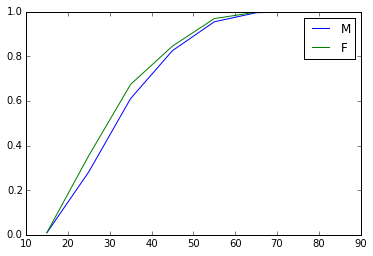

In [9]:
#print df.ageS, df.ageS.cumsum()

csM=df.ageM.groupby(pd.cut(df.ageM, bins)).agg([count_nonzero]).cumsum()

csF=df.ageF.groupby(pd.cut(df.ageF, bins)).agg([count_nonzero]).cumsum()

print np.abs(csM / csM.max()-csF / csF.max())

pl.plot(bins[:-1] + 5, csM / csM.max(), label = "M")
pl.plot(bins[:-1] + 5, csF / csF.max(), label = "F")
pl.legend()

they look pretty darn similar! that sets my expectation for the tests to come. if i wanted to code the KS test by hand i woud have everything i need: the normalized cumulative distributions can be subtracted from each other and the max distance can be seeked. 

Notice that there amay be Nan values you are gonna have to deal with! you can do that for example with a Boolean statementsuch as  df.ageF[~np.isnan(df.ageF)] or you can use numpy functions that deal with Nan values: nansum, nanmean, nanstd...

lets run the scipy KS test

In [10]:
import scipy.stats

#KS tests to compare 2 samples

http://docs.scipy.org/doc/scipy-0.15.1/reference/generated/scipy.stats.ks_2samp.html


In [17]:
#Full disclosure: I ran into problems with nans and ended up using Jeremy Neiman's solution 
#to create variables instead of adding to the df. This generates objects of different lengths,
#which requires them to be cut later.
ageM = 2015 - df['birth year'][(df['gender'] == 1) & (~np.isnan(df['birth year']))]
ageF = 2015 - df['birth year'][(df['gender'] == 2) & (~np.isnan(df['birth year']))]

print "KS 2-sample result using the dataframe: ", scipy.stats.ks_2samp(df.ageM, df.ageF)

print "KS 2-sample result using the variables: ", scipy.stats.ks_2samp(ageM, ageF)

print "KS 2-sample result using the variables cut to the same length: ", scipy.stats.ks_2samp(ageM[:len(ageF)], ageF)

KS 2-sample result using the dataframe:  (0.43313198412786136, 0.0)
KS 2-sample result using the variables:  (0.085139370088744726, 0.0)
KS 2-sample result using the variables cut to the same length:  (0.092142794604881784, 0.0)


remember: the Null hypothesis is rejected if

$D_KS(n1,n2) > c(\alpha) \sqrt{\frac{(n1+n2)}{n1n2}}$

where $c(\alpha$) is the inverse of the KS distribution, and you do not have to know how to get that cause there are tables that list critical values!! 

http://www.real-statistics.com/tests-normality-and-symmetry/statistical-tests-normality-symmetry/kolmogorov-smirnov-test/kolmogorov-distribution/

but scipy is already giving you the p-value, s you do not have to worry about it i am still giving you the table FWI and if you want to do the coding of the KS test by hand


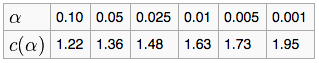

In [53]:
#here is the critical values tablel. Have you chosen your significance level yet?? you should do it first thing!
from IPython.display import Image
Image(filename="ks2sample_table.png")

###this cell is for you to tell me what the scipy KS test returned and what it means
**The KS 2-sample test indicates the liklihood of both samples coming from the same distribution. With a p-value of 0 (for the dataframe columns and variables), and a D-stat of less than .43 in all cases, the null that both samples are from the same distribution can be rejected at all confidence intervals. It's interesting to note the differences between the results for each set of variables and the the one coming off the dataframe produces a larger D-stat.**

#Pearson's  test for correlation

http://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.pearsonr.html#scipy.stats.pearsonr



In [18]:
#please perform the Pearson's test and tell me what you find
print scipy.stats.pearsonr(ageM[:len(ageF)], ageF) #accounts for length match issues resulting from NaN removal

(0.0024491632995350698, 0.25390149548734925)


**Pearson measures inter-dataset correlation. Pearson's null hypothesis is that the two datasets are not correlated.  The above results indicate that there is no correlation (correlation coefficient of .002) between the two samples. The p-value indicates that there a 25% chance that the .002 correlation could have been produced by an uncorrelated system.**

#Spearman's  test for correlation

http://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.spearmanr.html#scipy.stats.spearmanr

In [19]:
#please perform the Spearman's test and tell me what you find
print scipy.stats.spearmanr(ageM[:len(ageF)], ageF) #accounts for length match issues resulting from NaN removal

(0.0024367074462532889, 0.25632435082848903)


**Spearman measures inter-dataset correlation. Spearman's null hypothesis is that the two datasets are statistically independent of one another. Results indicate that the samples are uncorrelated (correlation coefficient of .002). The p-value indicates that there is a 25% chance that the .002 correlation could have been produced by an uncorrelated system.** 

##DO THE SAME FOR THE DISTRIBUTION OF RIDERS DURING THE DAY VS DURING THE NIGHT!

hint: remember how I converted the starttime last time in my own citibikes notebook into units that are easy to read. 
df['mystarttime'] = ...
then you can use something like
df['mystarttime'].dt.hour

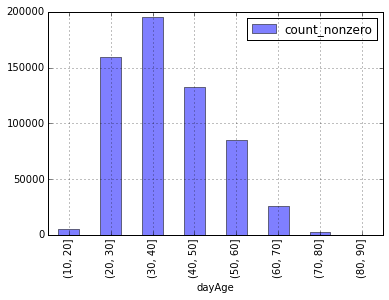

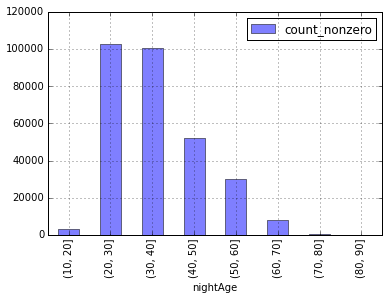

In [25]:
#creating new df columns for day and night 
df['dayAge'] = 2015-df['birth year'][(df['usertype'] == 'Subscriber') & (df.ts.dt.hour < 18)\
                                   & (df.ts.dt.hour >= 5)]
df['nightAge'] = 2015-df['birth year'][(df['usertype'] == 'Subscriber') & (df.ts.dt.hour >= 18)\
                                   |(df.ts.dt.hour < 5)]

#plotting 
df.dayAge.groupby(pd.cut(df.dayAge, bins)).agg([count_nonzero]).plot(kind='bar', alpha = .5)
df.nightAge.groupby(pd.cut(df.nightAge, bins)).agg([count_nonzero]).plot(kind='bar', alpha = .5)

#also creating variables for day and night
dayAge = 2015 - df['birth year'][((df.ts.dt.hour >= 5) & 
                                  (df.ts.dt.hour < 18)) & (~np.isnan(df['birth year']))]
nightAge = 2015 - df['birth year'][~((df.ts.dt.hour < 5) & 
                                     (df.ts.dt.hour >= 18)) & (~np.isnan(df['birth year']))]


In [34]:
nightAge1 = nightAge[:len(dayAge)] #cuts the bigger (night as I defined it) to the smaller (day)

          count_nonzero
dayAge                 
(10, 20]       0.002976
(20, 30]       0.085234
(30, 40]       0.101195
(40, 50]       0.056714
(50, 60]       0.016951
(60, 70]       0.002292
(70, 80]       0.000102
(80, 90]       0.000000


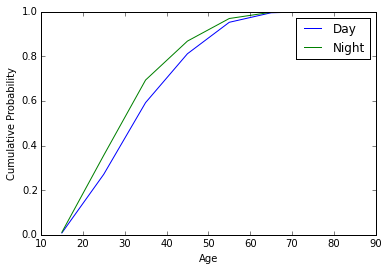

In [26]:
csD=df.dayAge.groupby(pd.cut(df.dayAge, bins)).agg([count_nonzero]).cumsum()

csN=df.nightAge.groupby(pd.cut(df.nightAge, bins)).agg([count_nonzero]).cumsum()

print np.abs(csD / csD.max()-csN / csN.max())

pl.plot(bins[:-1] + 5, csD / csD.max(), label = "Day")
pl.plot(bins[:-1] + 5, csN / csN.max(), label = "Night")
pl.xlabel("Age")
pl.ylabel("Cumulative Probability")
pl.legend()

##KS Test for Day/ Night

In [38]:
print "KS result:", scipy.stats.ks_2samp(dayAge, nightAge)#len function ensures two samples are same size to account for NaN removal

KS result: (0.036230235912546871, 0.0)


##Pearson Test for Day/ Night

In [35]:
print "Pearson result:", scipy.stats.pearsonr(dayAge, nightAge1) #len function ensures two samples are same size

Pearson result: (0.00092365840766188542, 0.47167585333796347)


##Spearman Test for Day/ Night 

In [36]:
print "Spearman result:", scipy.stats.spearmanr(dayAge, nightAge1) #len function ensures two samples are same size

Spearman result: (0.0010942668300230399, 0.39382534845123518)


**KS indicates both samples aren't from the same distribution. Pearson and Spearman both indicate that there is little correlation between the two as well.** 